# Cleaning Up Inconsistent Labels

From exploring our image data with their associated masks, we find that there are are some inconsistent labels for very similar images. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
% matplotlib inline
from data import load_train_data

In [2]:
imgs, masks, fnames = load_train_data()
subjects = np.load('np_data/subjects_train.npy')
imgs.shape, masks.shape, fnames.shape, subjects.shape

((5635, 420, 580), (5635, 420, 580), (5635,), (5635,))

In [3]:
def load_patient(pid):
    im = imgs[np.where(subjects==pid)]
    mk = masks[np.where(subjects==pid)]
    fn = fnames[np.where(subjects==pid)]
    return im, mk, fn

In [4]:
im, mk, fn = load_patient(29)
im.shape, mk.shape, fn.shape

((120, 420, 580), (120, 420, 580), (120,))

In [5]:
from skimage.util import view_as_blocks
# Blocks are non-overlapping views of the input array.
def compute_img_hist(img):
    """ Divide image into 21x29 blocks of size 20x20
        and compute a histogram for each row of 29 blocks """
    blocks = view_as_blocks(img.astype(np.float32)/255.0, block_shape=(20,20))
    hists = [np.histogram(block, bins=np.linspace(0,1,10))[0] for block in blocks]
    return np.concatenate(hists)

In [6]:
compute_img_hist(im[0])

array([  79,  461,  899, 1408, 1432, 2899, 2297,  980, 1145,   20,  112,
       1314, 2675, 2562, 2795, 1675,  339,  108,   20,    9,  349, 1102,
       2518, 2982, 2136, 1097, 1387,   20,    0,  815, 3799, 2901, 1864,
       1068,  553,  580,   20,  511, 3381, 4945, 1565,  531,  366,  135,
        146,   84, 1810, 5706, 2351,  753,  460,  173,   97,  166,   95,
       2285, 5565, 1797,  765,  502,  242,  113,  236,  491, 2165, 4159,
       2457, 1121,  612,  353,  137,  105,  414, 2635, 4082, 2298,  936,
        484,  291,  158,  302,  792, 3062, 3186, 1926, 1077,  853,  407,
        140,  157,  245, 2411, 3245, 1592, 1126, 1188,  752,  343,  698,
         22, 3090, 4453, 1656, 1094,  735,  437,  100,   13,  435, 1802,
       3389, 1713, 1291, 1248,  935,  376,  411,   86, 2199, 3704, 2186,
       1868,  981,  359,  103,  114,   67, 1742, 4538, 2175, 1000, 1193,
        547,  206,  132,   86, 1055, 5244, 2989,  931,  661,  375,  122,
        137,  554, 1661, 6135, 1589,  764,  617,  2

In [7]:
im_hists = [compute_img_hist(i) for i in im]
im_hists = np.array(im_hists)
im_hists.shape

(120, 189)

In [8]:
import scipy.spatial.distance as spdist

# Pairwise distances between observations and convert distance vector to a square-form distance matrix
dist = spdist.squareform(spdist.pdist(im_hists, metric='cosine'))


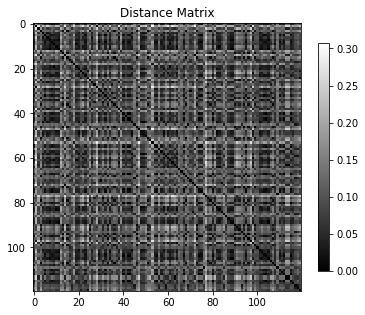

In [9]:
plt.figure(figsize=(6,6))
plt.imshow(dist, cmap=cm.gray)
plt.title("Distance Matrix")
plt.colorbar(shrink=0.7)
plt.show()

In [41]:
indu = np.triu_indices(dist.shape[0],k=1)
dist2 = dist[indu]
sim = dist2[dist2<0.008].shape[0]/dist2.shape[0]*100
dist2.shape

(7140,)

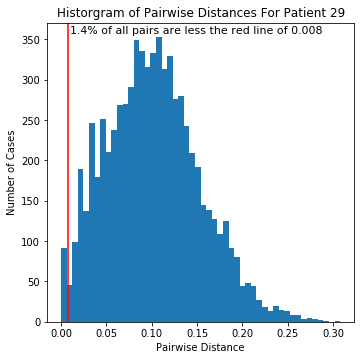

In [64]:
plt.figure(figsize=(5.5,5.5))
plt.hist(dist2, bins=50)
plt.axvline(0.008, color='r')
plt.text(0.01, 357, "{:.1f}% of all pairs are less the red line of 0.008".format(sim), fontsize=11)
plt.title("Historgram of Pairwise Distances For Patient 29")
plt.xlabel("Pairwise Distance")
plt.ylabel("Number of Cases")
plt.show()

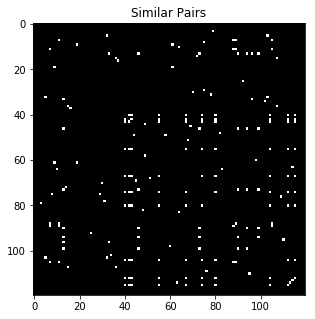

In [58]:
# Find similar pairs while excluding self-matching pairs
# Need to determine a threshold for similar pairs
close_pairs = ((dist + np.eye(dist.shape[0])) < 0.008)
plt.figure(figsize=(5,5))
plt.imshow(close_pairs, cmap=cm.gray)
plt.title("Similar Pairs")
plt.show()

In [59]:
close_ij = np.transpose(np.nonzero(close_pairs))
close_ij.shape

(206, 2)

In [60]:
# Check the upper bound of the set of the similar images 
farthest = np.argmax(dist[close_pairs])
farthest, close_ij[farthest]

(21, array([13, 99], dtype=int64))

In [63]:
# Find similar images that have inconsistent labels
smooth = 1
def dice(mask1, mask2):
    mask1 = (mask1.astype(np.float32)/255.0).flatten()
    mask2 = (mask2.astype(np.float32)/255.0).flatten()
    intersection = np.sum(np.multiply(mask1, mask2))
    return (2 * intersection + smooth) / (np.sum(mask1) + np.sum(mask2) + smooth)

In [103]:
# Plot the image pair that is most different among the set of similar images 
def plots(i,j):
    plt.figure(figsize=(12,8))
    plt.suptitle('Pairwise Distance of Two Images: {:.4f}\n Dice Coefficient of Two Masks: {:.3f}'
                 .format(dist[i,j], dice(mk[i],mk[j])), fontsize=14, fontweight='bold')
    # Dice Coefficient of Two Masks: {:.4f}, dice[mk[i],mk[j]]
    ax = plt.subplot(221)
    ax.set_title(fn[i])
    plt.imshow(im[i], cmap=cm.gray)
    ax = plt.subplot(222)
    ax.set_title(fn[j])
    plt.imshow(im[j], cmap=cm.gray)
    ax = plt.subplot(223)
    ax.set_title(fn[i]+" mask")
    plt.imshow(mk[i], cmap=cm.gray)
    ax = plt.subplot(224)
    ax.set_title(fn[j]+" mask")
    plt.imshow(mk[j], cmap=cm.gray)
    plt.show()

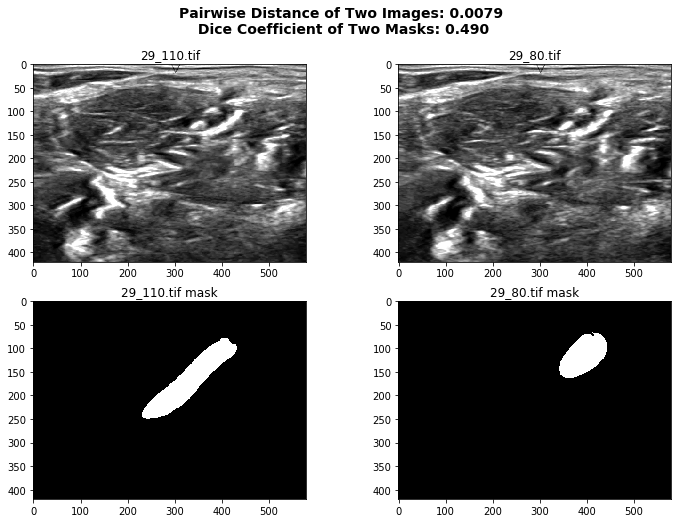

In [104]:
plots(close_ij[farthest,0], close_ij[farthest,1])

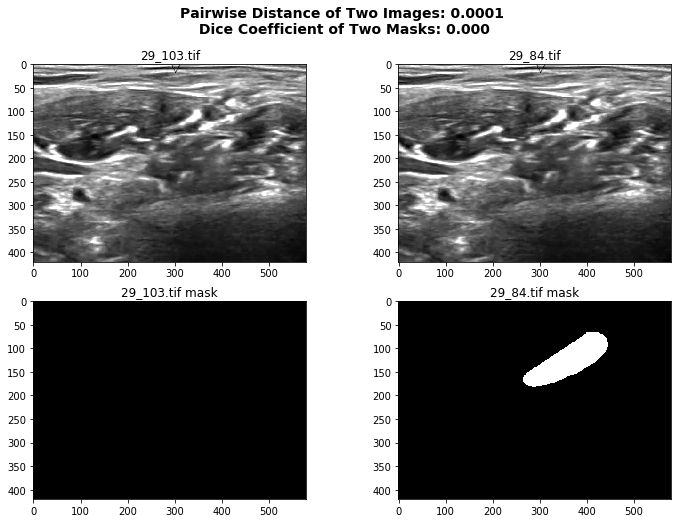

In [106]:
pair = 2
plots(close_ij[pair,0], close_ij[pair,1])

In [142]:
# Collect pairs that are similar but have very different masks
inconsistent = [(i, j) for i, j in close_ij if dice(mk[i], mk[j])<0.2]
inconsistent = np.array(inconsistent)
inconsistent.shape

(48, 2)

In [107]:
# among the similar pairs, what is the distribution of mask consistency
masksim = [dice(mk[i], mk[j]) for i, j in close_ij]
len(masksim)

206

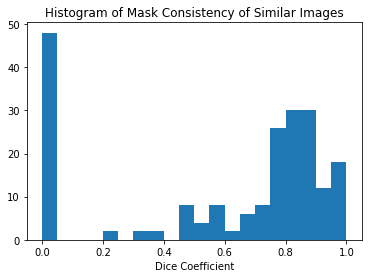

In [111]:
plt.hist(masksim, bins=20)
plt.title("Histogram of Mask Consistency of Similar Images")
plt.xlabel("Dice Coefficient")
plt.show()